In [2]:
import GPy
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from osprey.config import Config
from os.path import sys



In [20]:
# import database

all_dfs = []
strategies = ['Random', 'Sobol']
for strategy in strategies:
    df = p
# Load (arbirtrary) Configuation File


# Retrieve Trial Results
df = config.trial_results()


Loading config file:     alpha_angle.yaml...
Loading trials database: sqlite:///osprey-trails.db...


In [21]:
df = df.loc[df['status']=='SUCCEEDED', ['parameters', 'mean_test_score', 'project_name']]

# Variable Importance

This workbook im

In [22]:
variables = ['tica__lag_time', 'tica__n_components', 'cluster__n_clusters']
for variable in variables: 
    df[variable] = df['parameters'].apply(lambda x: x[variable])
del df['parameters']

In [23]:
df.head()

,mean_test_score,project_name,tica__lag_time,tica__n_components,cluster__n_clusters
0,2.001252,alpha_angle,228,10,990
1,2.303891,alpha_angle,247,5,547
2,2.815396,b-cont_ca,134,2,371
3,2.294570,alpha_angle,196,5,371
4,30.575240,all_tor,176,10,206


In [41]:
X = df.loc[df['project_name']=='alpha_angle', variables].values
Y = df.loc[df['project_name']=='alpha_angle', 'mean_test_score'].values[:, np.newaxis]

In [91]:
print(X.shape)
print(Y.shape)

(207, 3)
(207, 1)


In [98]:
kernel= GPy.kern.RBF(input_dim=3, ARD=True, lengthscale=[1,.2,.3])
kernel

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,"(3,)",+ve,


In [99]:
m = GPy.models.GPRegression(X,Y,kernel)
kernel.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.00000000,+ve,
[1],0.20000000,+ve,
[2],0.30000000,+ve,


In [100]:
m.optimize()

In [101]:
lens = np.array([x for x in kernel.lengthscale])
relevance = 1/lens

In [178]:
scaler = MinMaxScaler()
scaler.fit(X)
Xs = scaler.transform(X)

 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:Data with input dtype int64 was converted to float64 by MinMaxScaler.


In [200]:
from sklearn.utils import resample
num_bs = 100
relevance = np.zeros((num_bs, X.shape[1]))

for i in range(num_bs):
    # Bootstrap
    x, y = resample(Xs,Y, random_state=int(i), n_samples=int(Y.shape[0]*0.8))
#     kerns = [GPy.kern.Matern52(1, lengthscale=np.random.uniform(low=0.1, high=10.0, size=1), active_dims=[i]) 
#             for i in range(3)]
#     kernel=np.sum(kerns)
    kernel = GPy.kern.RBF(3, ARD=True, lengthscale=np.random.uniform(low=1, high=10.0, size=3))
    m = GPy.models.GPRegression(x,y,kernel)
    m.optimize()
    lens = np.array([x for x in kernel.lengthscale])
    relevance[i] = 1./lens  
    


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


In [201]:
relevance = pd.DataFrame(relevance, columns=variables)
relevance.head()

,tica__lag_time,tica__n_components,cluster__n_clusters
0,0.105876,0.549834,0.026100
1,0.101922,0.843204,0.032468
2,0.218427,0.933881,0.064363
3,0.165393,0.714842,0.036652
4,0.071547,0.464386,0.034650


In [202]:
melt_relevance = pd.melt(relevance)
melt_relevance.head()

,variable,value
0,tica__lag_time,0.105876
1,tica__lag_time,0.101922
2,tica__lag_time,0.218427
3,tica__lag_time,0.165393
4,tica__lag_time,0.071547


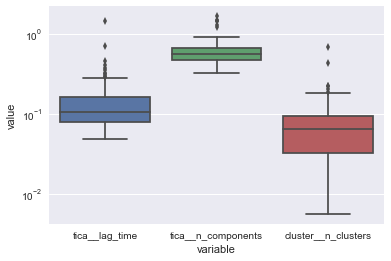

In [204]:
ax = sns.boxplot(x='variable', y='value', data=melt_relevance)
# ax.set_((0,0.1))
ax.set_yscale('log')

In [192]:
for i in range(10):
    x, y = resample(Xs,Y, random_state=i, n_samples=5)
    print(x)
    print()

[[ 0.20080321  0.          0.16804979]
 [ 0.53815261  0.55555556  0.94502075]
 [ 0.88353414  0.88888889  0.76244813]
 [ 0.46987952  0.11111111  0.38070539]
 [ 0.18473896  0.88888889  0.69605809]]

[[ 0.73895582  0.11111111  0.03008299]
 [ 0.36947791  0.66666667  0.45643154]
 [ 0.          0.44444444  0.8246888 ]
 [ 1.          0.55555556  0.90560166]
 [ 0.96787149  0.33333333  0.32676349]]

[[ 0.38554217  0.66666667  0.70850622]
 [ 0.53815261  0.33333333  0.06742739]
 [ 0.          0.44444444  0.8246888 ]
 [ 0.85140562  0.22222222  0.59854772]
 [ 0.70281124  0.55555556  0.4346473 ]]

[[ 0.94779116  0.22222222  0.97095436]
 [ 0.79919679  0.44444444  0.99377593]
 [ 0.92369478  0.11111111  0.04460581]
 [ 0.81927711  0.          0.07780083]
 [ 0.5502008   0.88888889  0.01244813]]

[[ 0.02008032  0.66666667  0.47821577]
 [ 0.86746988  0.55555556  0.84543568]
 [ 0.7751004   0.55555556  0.77178423]
 [ 0.59437751  0.66666667  0.35580913]
 [ 0.90361446  0.66666667  0.56120332]]

[[ 0.37349398  